# Milestone Project 1: Food Vision Big

See the annotated version of this notebook on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb

In [21]:
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installatio

## Check GPU

* Google Colab offers free GPUs, however, not all of them are compatible with mixed precision training.

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to a Tesla T4 (from withim Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+

In [ ]:
# Get GPU name
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-81beeae1-5f1c-5fc3-5e0d-3d8a07527b42)


## Get helper functions

In past modules, we've created a bunch of helper functions to do small task required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from there.

The script we've got available can be found of GitHub: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

In [1]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-01-10 12:28:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-01-10 12:28:29 (101 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import series of helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

If you want to get an overview of TensorFlow Datasets (TFDS), read the guide: https://www.tensorflow.org/datasets/overview

In [1]:
# Get TensorFlow datasets
import tensorflow_datasets as tfds


In [2]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS datasets?

True


In [3]:
# Load training data
#train_data, ds_info = tfds.load(
#    name="food101",
#    split="train",
#    shuffle_files=True,
#    as_supervised=True,  # data gets returned in tuple format (data, label)
#    with_info=True  # information about the data
#)



In [4]:
# Load validation data
#test_data = tfds.load(
 #   name="food101",
 #   split="validation",
  #  shuffle_files=True,
  #  as_supervised=True  # data gets returned in tuple format (data, label)
#)

In [5]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train","validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets return in tuple format (data,label)
                                             with_info=True) # information about the data

## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g are they one-hote encoded or are they label encoded)
* Do the labels match up with the class names?

In [6]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [7]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [8]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [9]:
# What does one sample of our training data look like
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
# Output info abot our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 16
  Class name (str form): cheesecake
  


It looks like our labels are not hot encoded because they don't look like [0, 0, 0,1...,0,0]

In [11]:
# What does our image tensor from TFD's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 85,  84,  92],
        [ 86,  85,  93],
        [ 93,  92, 100],
        ...,
        [120, 196, 245],
        [120, 198, 246],
        [121, 199, 247]],

       [[ 88,  88,  96],
        [ 82,  82,  90],
        [ 88,  88,  96],
        ...,
        [116, 192, 244],
        [118, 195, 249],
        [119, 196, 248]],

       [[ 77,  80,  89],
        [ 75,  78,  87],
        [ 82,  86,  95],
        ...,
        [115, 189, 252],
        [117, 192, 255],
        [118, 194, 255]],

       ...,

       [[159, 166, 194],
        [154, 161, 187],
        [171, 178, 204],
        ...,
        [219, 216, 235],
        [223, 220, 239],
        [227, 226, 244]],

       [[170, 179, 208],
        [169, 179, 206],
        [173, 183, 210],
        ...,
        [218, 217, 235],
        [223, 222, 240],
        [226, 227, 245]],

       [[168, 177, 206],
        [170, 179, 208],
        [152, 162, 189],
        ...,
        [224, 223, 24

In [12]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Dataset

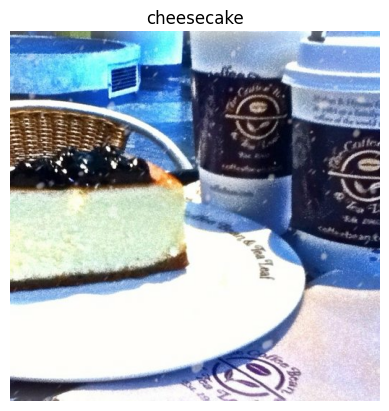

In [13]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is associated with the right image
plt.axis(False);

## Create preprocessing functions for our data

Neural networks perfom best when data is in a certain way (e.g. batched, normalized, etc).

However, not all data (including data from TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
*  For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perfom better

With these points in mind, we've got a few thing we can tackle with a preprocessing function.

Since we're goint to be using an EfficientNetBX pretrained model from tf.keras.applications we don't need to rescale our data (these architectures have rescaling built-in).

This means our function needs to:
1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from `uint8` to `float32`


In [14]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from `uint8` to `float32` and reshapes
  image to [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape])
  #image = img/255. # scale image values (not required with EfficientNet)
  return tf.cast(image, tf.float32), label #return (float_32 image, label) tuple

In [15]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 85  84  92]
  [ 86  85  93]
  [ 93  92 100]
  ...
  [120 196 245]
  [120 198 246]
  [121 199 247]]

 [[ 88  88  96]
  [ 82  82  90]
  [ 88  88  96]
  ...
  [116 192 244]
  [118 195 249]
  [119 196 248]]]..., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 84.67857   84.321434  92.321434]
  [ 87.19898   86.841835  94.841835]
  [ 84.72959   84.581635  94.72449 ]
  ...
  [119.50503  194.93877  245.85202 ]
  [114.974525 190.97452  241.90309 ]
  [119.071465 196.4286   247.82652 ]]

 [[ 75.647964  84.21939   93.21939 ]
  [ 71.45407   80.959175  89.959175]
  [ 78.03061   87.20408   97.47449 ]
  ...
  [113.31632  182.62755  249.35715 ]
  [106.57655  176.86227  245.4337  ]
  [108.601944 179.9796   248.16833 ]]]..., 
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


## Batch and prepare datasets

We're now going to make our data input pipeline run really fast.

For more resources on this, I'd highly going through the following guide: https://www.tensorflow.org/guide/data_performance

In [16]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocesing fuction to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)


buffer_size = it shuffles X samples at the time. Normally you would want all the length of the train_data but if our computer is not powerfull enough it is fine with putting a high number


In [17]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> "Hey, TensorFlow, map this preprocessing function (`preprocess_img`) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whislist the model is looking throught (fiding patterns) the current batch "

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard callback to log training results (so we can visualize them later if need be)
* ModelCheckpoint callback to save our model's progress after feature extraction.

In [18]:
# Create tensorboard callback (import from help_fuctions.py)
from helper_functions import create_tensorboard_callback

# Create a ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoint/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0) #don't print anything

## Setup mixed precision training

First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision: https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilizes a combination of float32 and float16 datatypes to speed up model performance.

In [19]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision


In [20]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [21]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16705208/16705208 [==============================] - 1s 0us/step


In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense_1 (Dense)             (None, 256)               327936    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 101)               13029 

## Checking layer dtype policies (are we using mixed precision?)

In [23]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)


input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
dense_2 True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going trough the above we see:
* `layer.name`: the human readeable name of a particular layer
* `layer.trainable`: is the layer trainable or not? (if `False`, the weights are frozen)
* `layer.dtype`: the data type a layer stores its variables in
* `layer.dtype_policy`: the data type policy a layer computes on its variables with.

In [24]:
# Check the dtype_policy attributes of layers in the base model
for layers in model.layers[1].layers: # check the layers of the base model(layer at index 1 of `model`)
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

softmax_float32 True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">
softmax_float32 True float32 <Policy "fl

In [25]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen)
2. Fine-tune some of the frozen layers

In [26]:
# Fit the feature extraction model with callback
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs =3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps = int(0.15*len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetbo_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])


Saving TensorBoard log files to: training_logs/efficientnetbo_101_classes_all_data_feature_extract/20250110-124927
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7935 - accuracy: 0.5430

2368/2368 [==============================] - 66s 23ms/step - loss: 1.7935 - accuracy: 0.5430 - val_loss: 1.2702 - val_accuracy: 0.6536
Epoch 2/3
2366/2368 [============================>.] - ETA: 0s - loss: 1.2676 - accuracy: 0.6631

2368/2368 [==============================] - 53s 22ms/step - loss: 1.2675 - accuracy: 0.6630 - val_loss: 1.1310 - val_accuracy: 0.6872
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.0644 - accuracy: 0.7092

2368/2368 [==============================] - 53s 22ms/step - loss: 1.0645 - accuracy: 0.7092 - val_loss: 1.1103 - val_accuracy: 0.6976


In [27]:
# Evaluate modek on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 12s 15ms/step - loss: 1.1160 - accuracy: 0.6994


[1.1160346269607544, 0.6993663311004639]

[0.9955309629440308, 0.7296633720397949

## Off to you...

We've covered a lot of ground so far but since this is a milestone project, it's time for you to takeover.

More specifically, you're challenge is to complete the TEMPLATE version of 07 to obtain a computer vision model (building off the one we've built in this notebook) to beat the DeepFood paper.

In other words, you're going to create Food Vision Big!

You can find the template here: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/TEMPLATE_07_food_vision_milestone_project_1.ipynb

## Save the whole model to file

In [ ]:
# Save model locally
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

In [ ]:
# Loaded model previously saved above
loaded_model = tf.keras.models.load_model(save_dir)

In [ ]:
# Check the layers in the base model and see wha dtype policy they're using
for layer in loaded_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <P

In [ ]:
# Check loaded model peformance (this shoul be the same results as results_feature_extract_model)
results_loaded_model = loaded_model.evaluate(test_data)

790/790 [==============================] - 15s 17ms/step - loss: 0.9955 - accuracy: 0.7297


In [ ]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables
import numpy as np
np.isclose(results_feature_extract_model,results_loaded_model).all()

True

## Preparing our model's layers for fine-tuning

**Next:** Fine-tune the feature extraction model to beat the DeepFood paper.

Like all good cooking shows, I've saved a model I prepared earlier (the feature extraction model from above) to Google Storage.

You can download it to make sure you're using the same model as originall trained going forward.

In [ ]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip

--2024-12-28 11:57:19--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.207, 172.253.118.207, 74.125.200.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  8.96MB/s    in 1.8s    

2024-12-28 11:57:22 (8.96 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [ ]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

mkdir: cannot create directory ‘downloaded_gs_model’: File exists
Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [ ]:
# Load and evaluate downloaded GS model
loaded_gs_model = tf.keras.models.load_model("downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [ ]:
# Get a summary of the download model
loaded_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [ ]:
# How does the loaded model perform?
results_loaded_gs_model = loaded_gs_model.evaluate(test_data)
results_loaded_gs_model

790/790 [==============================] - 15s 17ms/step - loss: 1.0881 - accuracy: 0.7067


[1.0880975723266602, 0.7066534757614136]

In [ ]:
# Set all of the layer .trainable variable in the loaded model to true (so they're unfrozen)
loaded_gs_model.trainable = True

In [ ]:
# Are any of the layers in our model frozen?
for layer in loaded_gs_model.layers:
    layer.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_gs_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [ ]:
# Compile the model
loaded_gs_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [ ]:
# Start to fine-tune (all layers)
# Use 100 epochs as the default
# Validate on 15% of the test_data
# Use the create_tensorboard_callback, ModelCheckpoint and EarlyStopping callbacks you created eaelier
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping] # stop model after X epochs of no improvements
                                                                   )

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20241228-120255
Epoch 1/100
2368/2368 [==============================] - 218s 76ms/step - loss: 0.9218 - accuracy: 0.7526 - val_loss: 0.7907 - val_accuracy: 0.7754
Epoch 2/100
2368/2368 [==============================] - 154s 65ms/step - loss: 0.5803 - accuracy: 0.8401 - val_loss: 0.7976 - val_accuracy: 0.7855
Epoch 3/100
2368/2368 [==============================] - 154s 65ms/step - loss: 0.3325 - accuracy: 0.9055 - val_loss: 0.8680 - val_accuracy: 0.7799
Epoch 4/100
2368/2368 [==============================] - 154s 65ms/step - loss: 0.1744 - accuracy: 0.9482 - val_loss: 0.9757 - val_accuracy: 0.7754


In [ ]:
results_fine_tune_model = loaded_gs_model.evaluate(test_data)
results_fine_tune_model

790/790 [==============================] - 14s 17ms/step - loss: 0.9581 - accuracy: 0.7782


[0.9580502510070801, 0.7781782150268555]

## Download fine-tuned model from Google Storage



In [ ]:
# Download and evaluate fine-tuned model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip

--2024-12-28 12:14:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.175.207, 74.125.24.207, 142.251.10.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.175.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46790356 (45M) [application/zip]
Saving to: ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip.1’

07_efficientnetb0_f 100%[===================>]  44.62M  14.5MB/s    in 3.1s    

2024-12-28 12:14:21 (14.5 MB/s) - ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip.1’ saved [46790356/46790356]



In [ ]:
# Unzip fine-tuned model
!mkdir downloaded_fine_tuned_gs_model # create separate directory for fine-tuned model downloaded from Google Storage
!unzip 07_efficientnetb0_fine_tuned_101_classes_mixed_precision -d downloaded_fine_tuned_gs_model

Archive:  07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/variables.index  
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/saved_model.pb  
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets/


In [ ]:
# Load in fine-tuned model from Google Storage and evaluate
loaded_fine_tuned_gs_model = tf.keras.models.load_model("downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

In [ ]:
# Get a model summary (same model architecture as above)
loaded_fine_tuned_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [ ]:
# Note: Even if you're loading in the model from Google Storage, you will still need to load the test_data variable for this cell to work
results_downloaded_fine_tuned_gs_model = loaded_fine_tuned_gs_model.evaluate(test_data)
results_downloaded_fine_tuned_gs_model

790/790 [==============================] - 18s 18ms/step - loss: 0.9072 - accuracy: 0.8017


[0.9072486758232117, 0.801663339138031]

## Evaluate your trained model

Some ideas you might want to go through:

1. Find the precision, recall and f1 scores for each class (all 101).
2.Build a confusion matrix for each of the classes.
3. Find your model's most wrong predictions (those with the highest prediction probability but the wrong prediction).

In [ ]:
# Make predictions with our model
preds_probs = loaded_fine_tuned_gs_model.predict(test_data,verbose=1)

790/790 [==============================] - 14s 16ms/step


In [ ]:
# How many predictions are there?
len(preds_probs)

25250

In [ ]:
# What's the shape of our predictions?
preds_probs.shape

(25250, 101)

In [ ]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

array([[6.9106136e-15, 1.7721228e-12, 1.1972746e-09, ..., 1.6320687e-14,
        7.5036402e-13, 9.4854897e-13],
       [1.2256056e-11, 4.0101663e-12, 2.3076917e-11, ..., 5.8558464e-14,
        9.3970456e-12, 3.2848321e-14],
       [7.8351029e-08, 2.0353325e-10, 8.5819779e-13, ..., 1.1065911e-10,
        5.3398865e-12, 2.7819694e-10],
       ...,
       [4.5991612e-07, 6.0327864e-08, 1.1318220e-05, ..., 1.6144574e-07,
        5.4534239e-04, 2.1633741e-09],
       [8.5558990e-12, 2.3097321e-18, 6.1718658e-15, ..., 4.0245622e-14,
        1.2448759e-11, 3.2202575e-16],
       [4.0444661e-07, 6.5510292e-08, 5.0017729e-10, ..., 6.7589809e-08,
        2.1694029e-06, 5.4851097e-07]], dtype=float32)

In [ ]:
# We get one prediction probability per class (in our case, there's 101 prediction probabilites)
print(f"Number of predictions probabilites for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]} ")
print(f"The class with the highest predicted proability by the model for sample 0: {preds_probs[0].argmax()} ")

Number of predictions probabilites for sample 0: 101
What prediction probability sample 0 looks like:
 [6.91061359e-15 1.77212281e-12 1.19727461e-09 4.23326399e-14
 3.39640677e-11 3.44989211e-11 8.46706077e-15 8.13783182e-19
 4.92100718e-13 9.19365170e-13 8.06717280e-12 3.69898526e-15
 1.91323934e-09 2.76043484e-13 3.83248419e-13 4.16136466e-11
 2.13758807e-12 1.38803384e-13 7.38730691e-13 2.24017311e-12
 2.38465172e-12 9.37777980e-11 4.50628643e-14 5.07721632e-13
 4.47388848e-10 3.35383192e-17 2.97221786e-15 3.31076117e-12
 2.47443776e-13 6.48215596e-12 2.48860753e-14 1.52216392e-10
 3.61545585e-11 7.07871955e-11 9.74552656e-15 1.48243344e-04
 4.48062811e-13 9.14130490e-12 6.80347451e-15 4.94174320e-11
 6.80347451e-15 1.75463919e-13 1.23195013e-14 7.54660887e-14
 3.15915024e-12 1.09802514e-13 6.72621952e-13 2.52019863e-08
 5.35134715e-14 3.17724091e-13 3.36796372e-15 1.22309302e-10
 1.13288021e-13 2.95529456e-14 1.42394061e-12 2.25300125e-13
 3.91512926e-14 5.93586812e-13 3.62090254e-

In [ ]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([65, 70, 34, 69, 23, 78, 13, 27, 27, 41])

In [ ]:
# How many pred classes do we have?
len(pred_classes)

25250

Let's compare the predictions with the original test dataset labels.

In [ ]:
# To get our test labels we need to unravel our test_data batchdaset
y_labels=[]
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# How many y_labels are there?
len(y_labels)

25250

### Evaluating our model's prediction

In [ ]:
results_downloaded_fine_tuned_gs_model

[0.9072486758232117, 0.801663339138031]

In [ ]:
# Let's try scikit-learn accuracy score function and see what it comes up
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true = y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.009861386138613861

In [ ]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(results_downloaded_fine_tuned_gs_model[1], sklearn_accuracy)

False

### Let's get visual: making a confusion matrix

In [ ]:
# Get a list of class names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
print("y_true:", np.unique(y_labels))
print("y_pred:", np.unique(pred_classes))


y_true: [0]
y_pred: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100]


In [ ]:
print("classes:", len(np.unique(y_labels)))
print("Number of classes:", len(class_names))


classes: 1
Number of classes: 101


In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
# we need to make some changes to our function to ensure x-labels are vertically
# Note: The following confusion matrix code is a remix of Scikit-Learn's
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)


  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True);

Output hidden; open in https://colab.research.google.com to view.

### Let's make a classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels,pred_classes, output_dict=True)
classification_report_dict

In [ ]:
# create an empty dictionary
class_f1_scores={}
# loop through classification report dictionary itmes
for k, v in classification_report_dict.items():
  if k == "accuracy": #stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) #get f1scores values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_name"])
ax.set_xlabel("F1-score")
ax.set_title("F1-score for 101 Different food Classes (predicted by Food Vision Mini)")
ax.invert_yaxis();# reverse the order of our plot


In [ ]:
# Create a function to load and prepare images
def load_and_prep_images(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into specfied
  shape (img_shape, img_shape, color_channels=3)

  Arg:
    filename (str): path to target image
    image_shape (int): height /width dimension of target image size
    scale(bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, color_channels)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, size=[img_shape, img_shape])

  # Scale? Yes/no
  if scale:
    # rescale the image (get all of the values between 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale images for EfficientNet models in TensorFow



In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(20,15))
for i in range(3):
  # Choose a random image(s) from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir  + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_images(filepath, scale=False)
  img_expanded = tf.expand_dims(img, axis=0)
  pred_prob = model.predict(img_expanded) # get prediction probabilites array
  pred_class = class_names[pred_prob.argmax()] #get highest prediction probability index

  # plot the image(s)
  plt.subplot(1,3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:# if predicted class matches truth class, make text green
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"Actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);